In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
data = pd.read_excel("Lot100_DisCharge.xlsx")
print("Rows loaded:", len(data))


Rows loaded: 306


In [7]:
data.head()

,Date,Time,Pack Vol,Curent,Soc,Rem. Ah,Full Cap,CMS,DMS,Cell1,...,C_Diff,Temp1,Temp2,Temp3,Temp4,Cycle,Err_Stat,Bal_Stat1-16,Bal_Stat17-24,Bat.No
0,2025-03-17,06:03:41,48.85,0.0,0.63,34290,54000,1,1,3761,...,6,26.2,24.6,NaN,NaN,1,0,0,0,65407
1,2025-03-17,06:03:42,48.85,0.0,0.63,34290,54000,1,1,3761,...,6,26.2,24.6,NaN,NaN,1,0,0,0,65407
2,2025-03-17,06:03:43,48.85,0.0,0.63,34290,54000,1,1,3761,...,6,26.2,24.6,NaN,NaN,1,0,0,0,65407
3,2025-03-17,06:03:44,48.85,0.0,0.63,34290,54000,1,1,3761,...,6,26.2,24.6,NaN,NaN,1,0,0,0,65407
4,2025-03-17,06:03:45,48.85,0.0,0.63,34290,54000,1,1,3761,...,6,26.2,24.6,NaN,NaN,1,0,0,0,65407


In [8]:
data.columns = data.columns.str.strip()

In [9]:
data['Date Time'] = pd.to_datetime(
    data['Date'].astype(str) + ' ' + data['Time'].astype(str),
    errors='coerce'
)

data = data.dropna(subset=['Date Time'])
data = data.sort_values('Date Time').reset_index(drop=True)

In [10]:
data.rename(columns={
    'Pack Vol': 'Voltage',
    'Curent': 'Current',
    'Soc': 'SOC'
}, inplace=True)

In [11]:
data['SoH'] = (data['Rem. Ah'] / data['Full Cap']) * 100
data = data[data['SoH'].notna()]

In [12]:

data['Temp_avg'] = data[['Temp1','Temp2','Temp3','Temp4']].mean(axis=1)
data['Temp_diff'] = data[['Temp1','Temp2','Temp3','Temp4']].max(axis=1) - \
                    data[['Temp1','Temp2','Temp3','Temp4']].min(axis=1)


data['Volt_diff'] = data['C_N_High'] - data['C_N_Low']


data['Current_smooth'] = data['Current'].rolling(3).mean()
data['Voltage_smooth'] = data['Voltage'].rolling(3).mean()


data = data.dropna(subset=['Current_smooth','Voltage_smooth'])


In [13]:
data['dSoC'] = data['SOC'].diff()
data['dVolt'] = data['Voltage_smooth'].diff()
data['dTemp'] = data['Temp_avg'].diff()


In [14]:
data['Stress_Index'] = (
    np.abs(data['Current_smooth']) *
    data['Temp_avg'] *
    data['Volt_diff']
)


In [15]:
data['Cycle_norm'] = data['Cycle'] / data['Cycle'].max()


In [16]:
features = [
    'Voltage_smooth',
    'Current_smooth',
    'SOC',
    'Cycle_norm',
    'Temp_avg',
    'Temp_diff',
    'Volt_diff',
    'dSoC',
    'dVolt',
    'dTemp',
    'Stress_Index'
]


X = data[features]
y = data['SoH']

print("Final dataset size:", len(data))

Final dataset size: 304


In [17]:
split_idx = int(len(data) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]


In [18]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=22,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",22
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [19]:
y_pred = rf_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



MAE: 0.39902929768216977
RMSE: 0.4488674080853615


In [20]:

residuals = np.abs(y_test.values - y_pred)
threshold = residuals.mean() + 3 * residuals.std()

data_test = data.iloc[split_idx:].copy()
data_test['Abnormal_Aging'] = residuals > threshold

print("Abnormal aging events detected:",
      data_test['Abnormal_Aging'].sum())

Abnormal aging events detected: 0


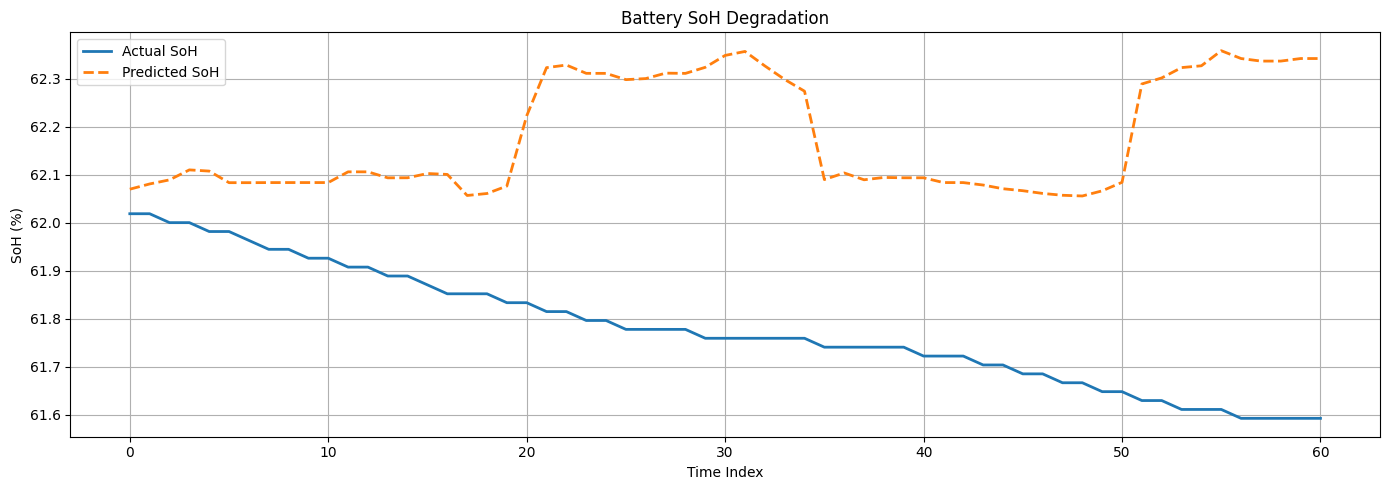

In [21]:
plt.figure(figsize=(14, 5))

plt.plot(y_test.to_numpy(), label='Actual SoH', linewidth=2)
plt.plot(y_pred, label='Predicted SoH', linewidth=2 , linestyle='--')


plt.xlabel("Time Index")
plt.ylabel("SoH (%)")
plt.title("Battery SoH Degradation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [22]:
data['Cycle_norm'] = data['Cycle'] / data['Cycle'].max()


In [23]:
data['Temp_Imbalance'] = data[['Temp1','Temp2','Temp3','Temp4']].max(axis=1) - \
                         data[['Temp1','Temp2','Temp3','Temp4']].min(axis=1)

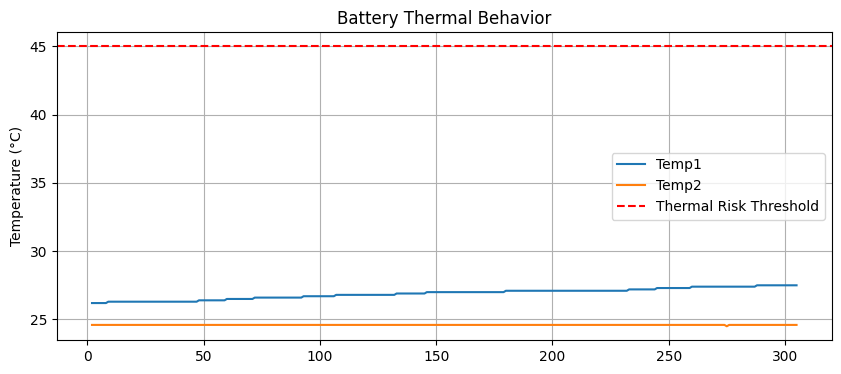

In [24]:
plt.figure(figsize=(10,4))
plt.plot(data['Temp1'], label='Temp1')
plt.plot(data['Temp2'], label='Temp2')
plt.axhline(45, linestyle='--', color='r', label='Thermal Risk Threshold')
plt.legend()
plt.title("Battery Thermal Behavior")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [25]:


def second_life_decision(current_soh):
    if current_soh>= 80:
        return (
            "Grade A – EV Use",
            "Battery is in excellent health. Suitable for direct reuse in "
            "electric vehicles with high power demand and long-range requirements. "
            "Minimal degradation risk in short-to-medium term."
        )
    elif current_soh >= 60:
        return (
            "Grade B – Solar / Home Storage",
            "Battery shows moderate degradation. Not ideal for EV propulsion, "
            "but highly suitable for stationary energy storage such as solar, "
            "UPS, or microgrid applications with lower current stress."
        )
    else:
        return (
            "Grade C – Recycling",
            "Battery is significantly degraded. Reuse is not economically viable. "
            "Recommended for material recovery and recycling to extract lithium, "
            "cobalt, nickel, and other valuable components."
        )
deg_data = data[['Cycle', 'SoH']].dropna().sort_values('Cycle')
current_cycle = deg_data['Cycle'].max()
current_soh = data.loc[data['Cycle'] == current_cycle, 'SoH'].mean()



grade, description = second_life_decision(current_soh)


second_life_summary = pd.DataFrame({
    'Metric': ['State of Health (SoH)', 'Second-Life Grade', 'Decision Description'],
    'Value': [f"{current_soh:.2f} %", grade, description]
})

second_life_summary


,Metric,Value
0,State of Health (SoH),62.60 %
1,Second-Life Grade,Grade B – Solar / Home Storage
2,Decision Description,Battery shows moderate degradation. Not ideal ...


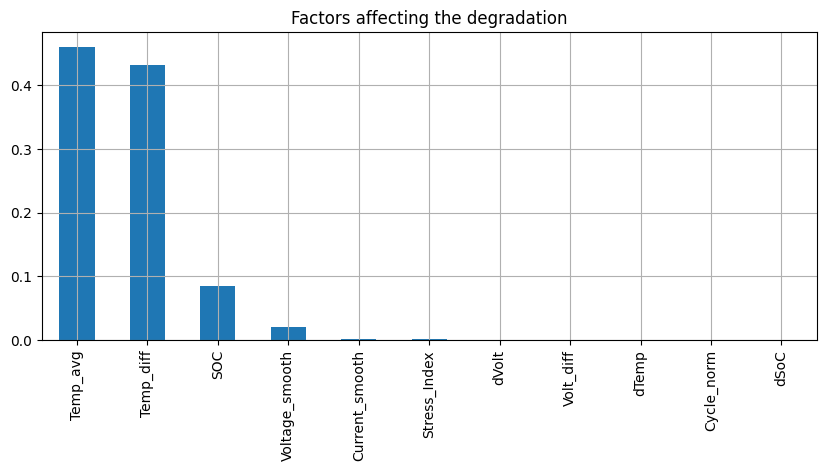

In [26]:
importances = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(kind='bar', figsize=(10,4), title="Factors affecting the degradation")
plt.grid(True)
plt.show()

In [27]:
importance_df = pd.DataFrame({
    'Factor': importances.index,
    'Impact (%)': importances.values * 100
})

importance_df['Impact (%)'] = importance_df['Impact (%)'].round(2)

importance_df


,Factor,Impact (%)
0,Temp_avg,46.00
1,Temp_diff,43.09
2,SOC,8.42
3,Voltage_smooth,2.02
4,Current_smooth,0.23
5,Stress_Index,0.11
6,dVolt,0.10
7,Volt_diff,0.03
8,dTemp,0.00
9,Cycle_norm,0.00
